In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, DecisionBoundaryDisplay

In [3]:
from sklearn.ensemble import RandomForestRegressor as RF

## Zbiór concrete

Będziemy używać podziału na zbiór treningowy i testowy (hold-out), stąd funkcja `train_test_split`

In [24]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)

## Wewnętrzna miara ważności zmiennych (algorytmy oparte o drzewa decyzyjne)

- oparte na impurity/RMSE, opisuje jak zmienna przyczynia się do wzrostu czystości/zmiejszenia błędu

wady: 
- może przykrwać podobną wysoce skorelowaną zmienną
- nie pokazuje kierunkowości ani jaki zakres zmiennej jest istotny
- pokazuje znaczenie zmiennej wyłącznie w zbiorze treningowym, może nie być to słuszne dla zbioru testowego
- ma znaczenie interpretacyjne tylko dla "dobrych modeli"

Zalety:
- łatwo dostępna, 
- intuicyjnie prosta do zrozumienia

In [5]:
estimator = RF().fit(X_train,y_train) # jak było trenowane drzewo
est_std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)
pd.DataFrame(estimator.feature_importances_,index=X.columns)

,0
cement,0.312068
slag,0.082926
flyash,0.016346
water,0.087964
superplasticizer,0.091939
coarseaggregate,0.031368
fineaggregate,0.040008
age,0.337382


## Ocena ważności zmiennej poprzez powtarzalne perturbacje wybranych zmiennych

- działa na podstawie losowego przemieszania wybranej zmiennej i sprawdzenia spadku wydajności estymatora
Zalety:
- analizuje rolę zmiennej w wytrenowanym modelu
- może być sprawdzana zarówno dla zbioru treningowego i testowego

In [6]:
trained = permutation_importance(estimator, X_train, y_train, n_repeats=30,random_state=0)
tested = permutation_importance(estimator, X_test, y_test, n_repeats=30,random_state=0)
pd.DataFrame(zip(trained['importances_mean'],tested['importances_mean']),index=X.columns,columns=["train","test"])

,train,test
cement,0.655860,0.573907
slag,0.171982,0.155514
flyash,0.009978,0.005747
water,0.150207,0.129957
superplasticizer,0.117243,0.094208
coarseaggregate,0.023966,0.014821
fineaggregate,0.044306,0.043524
age,0.771424,0.764850


Text(0.5, 1.0, 'Testing set')

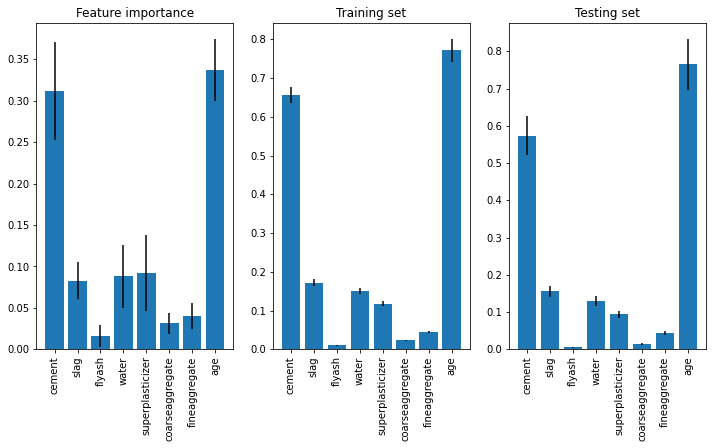

In [7]:
fig,axes = plt.subplots(ncols=3,figsize=(12,6))
axes[0].bar(X.columns,estimator.feature_importances_,yerr=est_std)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_title("Feature importance")

axes[1].bar(X.columns,trained.importances_mean,yerr=trained.importances_std)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_title("Training set")

axes[2].bar(X.columns,tested.importances_mean,yerr=tested.importances_std)
axes[2].tick_params(axis='x', labelrotation=90)
axes[2].set_title("Testing set")

## Ocena ważności zmiennych poprzez kombinacyjne usuwanie wybranych zmiennych

- działa podobnie jak metoda permutacyjnego usuwania zmiennych, z tą różnicą że za każdym razem trenowane są inne modele
- odpowiada czy można wytrenować dobry model bez danej zmiennej
- można stosować dla jednej lub dwóch zmiennych, dla większej liczby zmiennych może być problem z ekslozją kombinatoryczną

In [8]:
yhat =RF().fit(X,y).predict(X)
mae = mean_absolute_error(y,yhat)

inc_error = []
for v in X.columns:
    Xdash = X.drop(columns=v)
    model = RF().fit(Xdash,y)
    yhat = model.predict(Xdash)
    inc_error.append(mean_absolute_error(y,yhat)-mae)

pd.DataFrame(inc_error,X.columns)

,0
cement,0.243173
slag,0.034675
flyash,-0.014223
water,0.075972
superplasticizer,0.032554
coarseaggregate,0.016661
fineaggregate,0.006619
age,6.309817


Dla dwóch zmiennych jest to zadanie trudniejsze, gdyż wymaga wyliczenia kombinacji zmiennych oraz są problemy z wizualizacją wyników. Wyniki kombinacyjnego usuwania dwóch zmiennych warto porównać z analizą korelacji pomiędzy zmiennymi.

In [9]:
from itertools import combinations
yhat =RF().fit(X,y).predict(X)
mae = mean_absolute_error(y,yhat)

inc_error = []
for v in combinations(X.columns,2):
    Xdash = X.drop(columns=list(v))
    model = RF().fit(Xdash,y)
    yhat = model.predict(Xdash)
    inc_error.append(mean_absolute_error(y,yhat)-mae)

In [10]:
m = np.zeros((len(X.columns),len(X.columns)))
m[np.triu_indices(len(X.columns),1)] = np.array(inc_error)
m = pd.DataFrame(m,columns=X.columns,index=X.columns)
m

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,0.0,0.466736,0.378786,0.665858,0.264700,0.404283,0.667112,6.457851
slag,0.0,0.000000,0.205853,0.200411,0.117992,0.127454,0.284173,6.382037
flyash,0.0,0.000000,0.000000,0.092306,0.055228,0.055308,0.017160,6.333153
water,0.0,0.000000,0.000000,0.000000,0.180734,0.131524,0.112975,6.348184
superplasticizer,0.0,0.000000,0.000000,0.000000,0.000000,0.060117,0.053621,6.351160
coarseaggregate,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.056769,6.374085
fineaggregate,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.309247
age,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

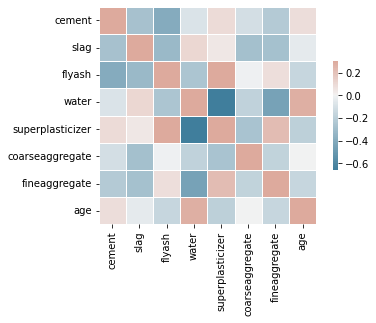

In [11]:
corr = X.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

## Granice decyzyjne

Wizualizacja granic decyzyjnych to wizualizacja uproszczonego estymatora, wytrenowanego na dwóch najważniejszych zmiennych. 

Zalety:
- określenie obszarów dobrej i złej predykcji
- określenie działania estymatora poza zakresem zmiennych

Wady:
- ujęcie tylko dwóch zmiennych

Uwaga: Funkcja pozwala na dostęp do wyników danych wejściowych i wyników estymacji poprzez atrybuty: .xx0, .xx1, .response

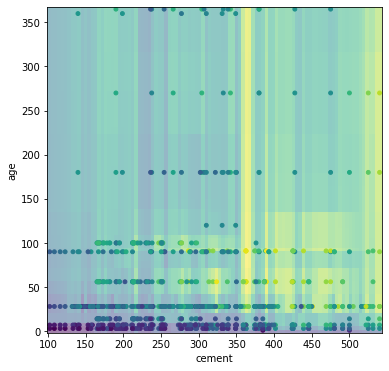

In [12]:
Xdash = X.iloc[:,[0,-1]] # pierwsza i ostatnia zmienna
regressor = RF().fit(Xdash, y)
fig,ax = plt.subplots(figsize=(6,6)) # warto to zrobić aby sterować ryciną
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=ax
)

disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)

### Porównanie granic decyzyjnych dla różnych estymatorów



In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
reg_01 = DecisionTreeRegressor().fit(Xdash, y)
reg_02 = KNeighborsRegressor().fit(Xdash, y)
reg_03 = LinearRegression().fit(Xdash, y)
reg_04 = MLPRegressor().fit(Xdash, y)

Text(0.5, 1.0, 'Neural Network')

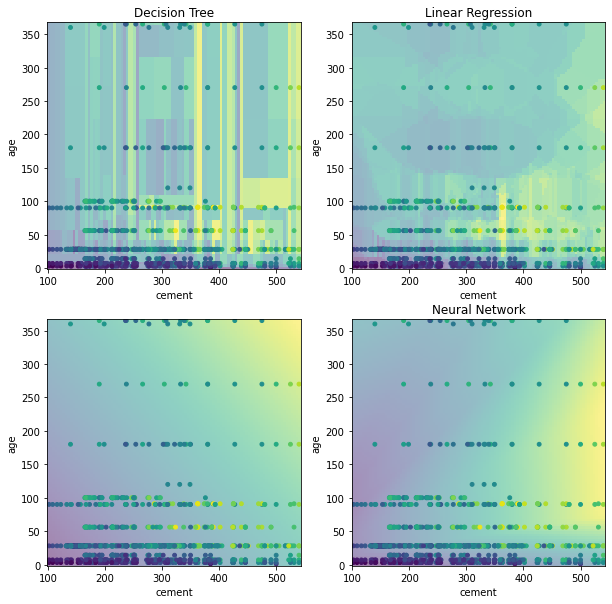

In [14]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
disp = DecisionBoundaryDisplay.from_estimator(
    reg_01, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[0][0]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][0].set_title("Decision Tree")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_02, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[0][1]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][1].set_title("k-NN")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_03, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[1][0]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][1].set_title("Linear Regression")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_04, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[1][1]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[1][1].set_title("Neural Network")

## Partial dependence (zależność częściowa)

Podsawą obliczania jest zasada 'ceteris paribus' (pozostali wszystcy równi). Zmienne, za wyjątkiem opisywanej ustawiane są na wartość średnią, a zmienna opisywana przyjmuje wartości w przedziale [min,max] rozłożone regularnie. Wykres pokazuje, które wartości zmiennej zwiększają modelowaną wartość (lub prawdpoodobeństwo klasy) a które zmiejszają.

In [15]:
regp_01 = DecisionTreeRegressor().fit(X, y)
regp_02 = KNeighborsRegressor().fit(X, y)
regp_03 = LinearRegression().fit(X, y)
regp_04 = MLPRegressor().fit(X, y)

/home/jarekj/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0.5, 0.98, 'Decision Tree')

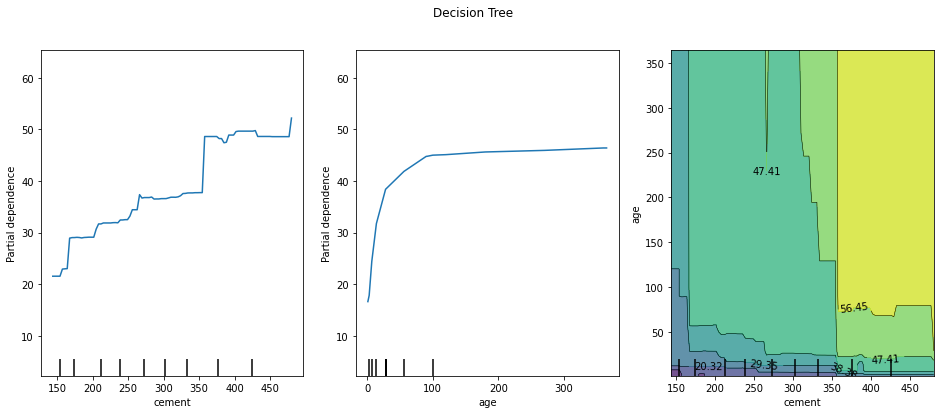

In [16]:
fig, axes = plt.subplots(ncols=3,figsize=(16,6))
PartialDependenceDisplay.from_estimator(regp_01, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Decision Tree")

Text(0.5, 0.98, 'k-NN')

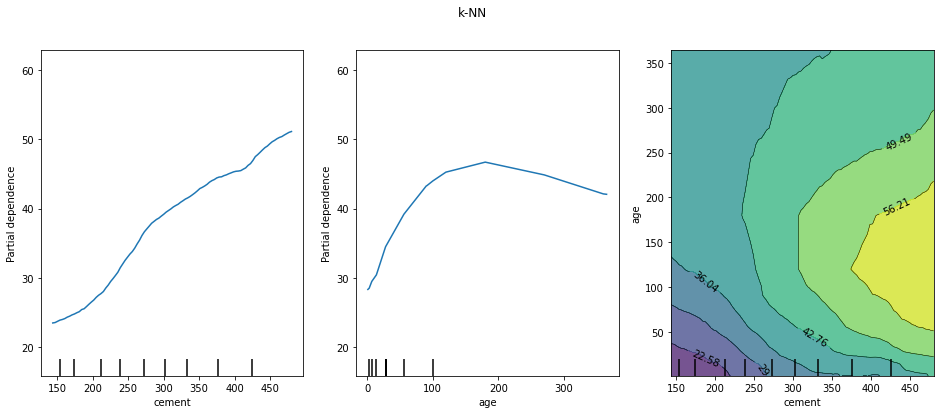

In [17]:
fig, axes = plt.subplots(ncols=3,figsize=(16,6))
PartialDependenceDisplay.from_estimator(regp_02, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("k-NN")

Text(0.5, 0.98, 'Linear regression')

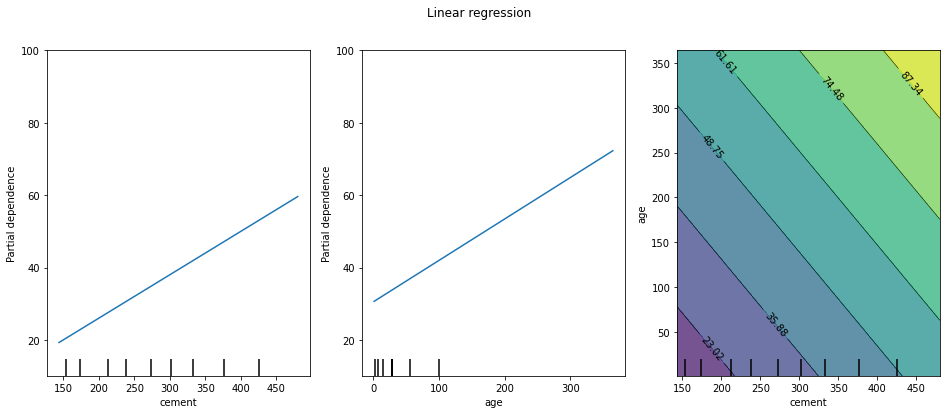

In [18]:
fig, axes = plt.subplots(ncols=3,figsize=(16,6))
PartialDependenceDisplay.from_estimator(regp_03, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Linear regression")

Text(0.5, 0.98, 'Neural network')

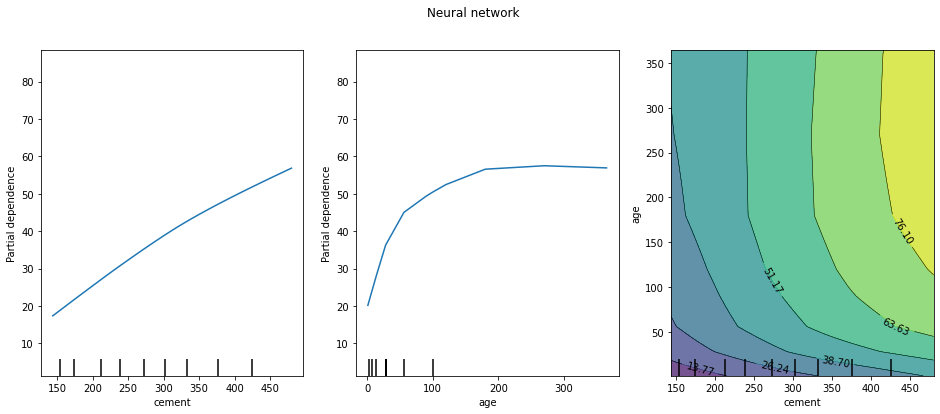

In [19]:
fig, axes = plt.subplots(ncols=3,figsize=(16,6))
PartialDependenceDisplay.from_estimator(regp_04, X, features=["cement","age",("cement","age")],ax=axes)
fig.suptitle("Neural network")

Zmiennych opisujące wykresy znadują się w słowniku:
pdp['average'][0] - wartości pdp
pdp['values'] - wartości zmiennej

In [27]:
from sklearn.inspection import partial_dependence
pdp = partial_dependence(regp_04,X,features=["cement"])

## Accumulated local effect

W przeciwieństwie do PDP, ALE dla poszczeglnych wartości badanej zmiennej używa wartości średniej z otoczenia, gdzie dana wartość się znajduje. Pozwala to uniknąć sytuacji typowych dla PDP, że wartości średnie pozostałych zmiennych i wartość opisywanej zmiennej tworzą nieistniejącą konfigurację i tym samym wynik predykcji niewiele ma wspólnego z rzeczywistością.

Wyniki do zbudowania wykresu znajdują się w słowniku:
ale['ale_values']
ale['feature_values']

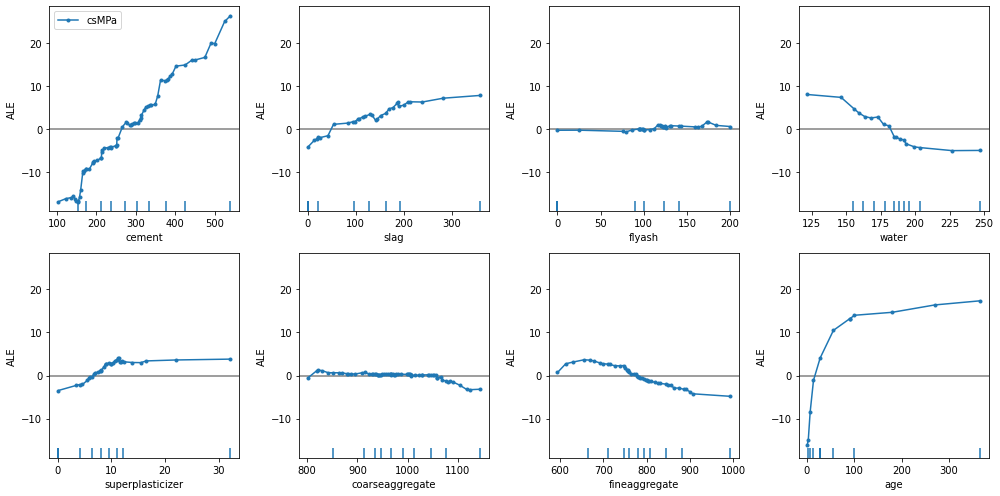

In [34]:
from alibi.explainers import ALE, plot_ale
Xn, yn = X.to_numpy(), y.to_numpy()
reg_01a = RF().fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict, feature_names=X.columns, target_names=[y.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

## Co z klasyfikacjami

.predict() zastępujemy .predict_proba()

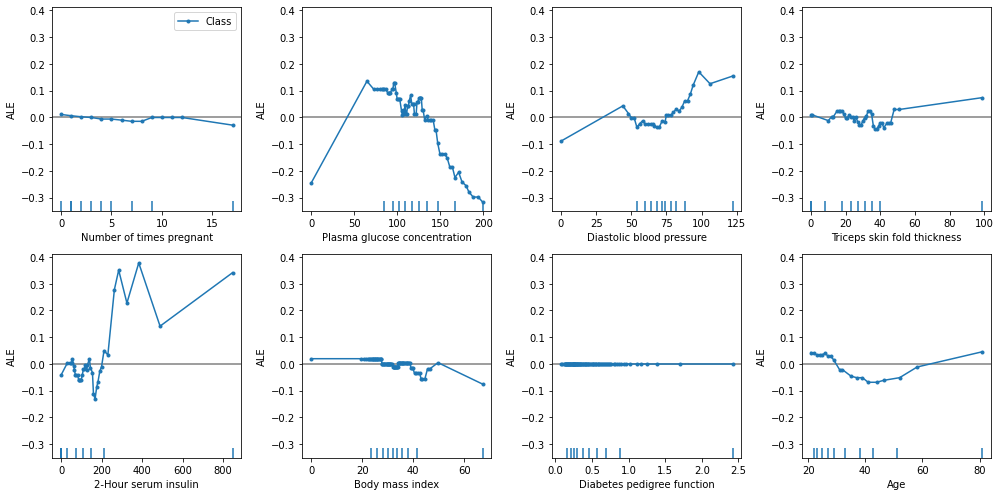

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("Datasets/diabetes_class.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
Xn, yn = X.to_numpy(), y.to_numpy()

cls_01a = KNeighborsClassifier().fit(Xn, yn)
cls_01_ale = ALE(cls_01a.predict_proba, feature_names=X.columns, target_names=[y.name]) # probability
cls_01_ale_exp = cls_01_ale.explain(Xn)
plot_ale(cls_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7});